In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gwyfile as gwy
import os
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
import cv2
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

from utils import cut_img,compare,over,get_dx,keepLargestArea,runKmeans,getMaskLevels,surfmap,volmap,get_Mask,createNewDataRow,addData,glassSubtraction
#from utilsRF import makemask,makerect

In [3]:
folderpath = "/home/david/Dropbox/ResearchProjects/DataAnalysis/BiologicalCells/ImageSegmentation/pythonScripts/dataMagdaYoda/"

files = sorted( os.listdir(folderpath) )

ii =5
CellNo = 1

filename1 = files[2*ii]
filename2 = files[2*ii+1]
print(filename1,filename2)

#filepath = os.getcwd() + "/testdata/" + filename
objP = gwy.load(folderpath + filename1)


#filepath = os.getcwd() + "/testdata/" + filename
objT = gwy.load(folderpath + filename2)

# cut image reduces the original gwy image to only
# the part with the cell mask. IT seperates the images in topog, friction and mask
img,imgP,imgM = cut_img(objT,objP,Nmask=CellNo)

FileNotFoundError: [Errno 2] No such file or directory: '/home/david/Dropbox/ResearchProjects/BiologicalCells/ImageSegmentation/pythonScripts/dataMagdaYoda/'

In [75]:
#filepath = os.getcwd() + "/testdata/ctrl_2_1.gwy"
#obj = gwy.load(filepath)

#channels = gwy.util.get_datafields(obj)
#channel = channels['Detail 1']
#img     = channel.data*1e6


# Make training Masks

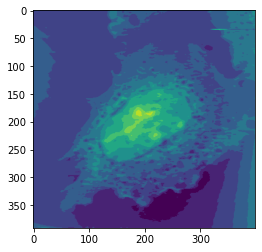

In [76]:
alpha = 10
beta = 20
img2 = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
plt.imshow(img2)


In [77]:
def makemask(img,range_list):
    mask = np.zeros(img.shape,np.uint8)
    for rangei in range_list:
        mask[ rangei[2]:rangei[3],rangei[0]:rangei[1]] = 255
    
    return mask
    
def makerect(range_list,c):
    out = []
    for rangei in range_list:
        out.append( patches.Rectangle((rangei[0], rangei[2]), (rangei[1]-rangei[0]), rangei[3]-rangei[2], linewidth=1, edgecolor=c, facecolor='none') )
    
    return out

def showRange(img,rangeG,rangeC,rangeN):

    #masked_img = cv2.bitwise_and(img,img,mask = msk)
    fig, ax = plt.subplots()
    ax.imshow(img)
    rectg = makerect(rangeG,'b')
    rectc = makerect(rangeC,'r')
    rectn = makerect(rangeN,'g')

    for recti in rectc:
        ax.add_patch(recti)
    for recti in rectg:
        ax.add_patch(recti)
    for recti in rectn:
        ax.add_patch(recti)

    plt.show()
def makeTrainingLabels(img,rangeG,rangeC,rangeN):
    training_labels = np.zeros(img.shape[:2], dtype=np.uint8)
    for rangegi in rangeG:
        training_labels[rangegi[2]:rangegi[3],rangegi[0]:rangegi[1] ] = 1
    for rangeci in rangeC:
        training_labels[rangeci[2]:rangeci[3],rangeci[0]:rangeci[1]] = 2
    for rangeni in rangeN:
        training_labels[rangeni[2]:rangeni[3],rangeni[0]:rangeni[1]] = 3
    return training_labels


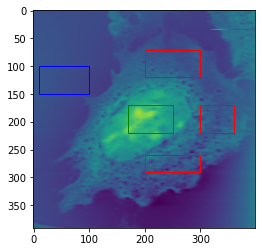

In [103]:
# xi,xf,yi,yf
rangeG=[ [10,100,100,150]]
rangeC=[ [200,300,70,120],
        [200,300,260,290],[300,360,170,220]]
rangeN=[[170,250,170,220]]

mskG = makemask(img,rangeG)
mskC = makemask(img,rangeC)
mskN = makemask(img,rangeN)

#masked_img = cv2.bitwise_and(img,img,mask = msk)
showRange(img,rangeG,rangeC,rangeN)

In [104]:
training_labels = makeTrainingLabels(img,rangeG,rangeC,rangeN)


In [105]:

# Build an array of labels for training the segmentation.
# Here we use rectangles but visualization libraries such as plotly
# (and napari?) can be used to draw a mask on the image.


# Creates features that can then be used for the classifier
sigma_min = 1
sigma_max = 4
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=True, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max)

features = features_func(img)

clf = RandomForestClassifier(n_estimators=200, n_jobs=-1,
                             max_depth=10, max_samples=0.05)

clf = future.fit_segmenter(training_labels, features, clf)

img_labels = future.predict_segmenter(features, clf)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


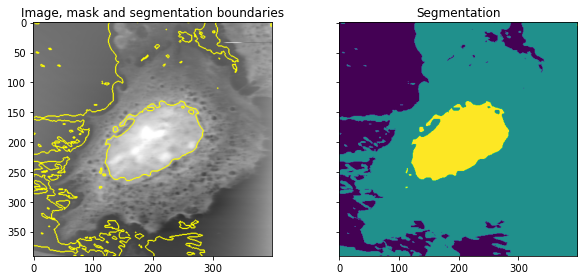

In [106]:

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(img, img_labels, mode='thick'))
#ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')

ax[1].imshow(img_labels)
ax[1].set_title('Segmentation')
fig.tight_layout()


# Tidy up Nucleus

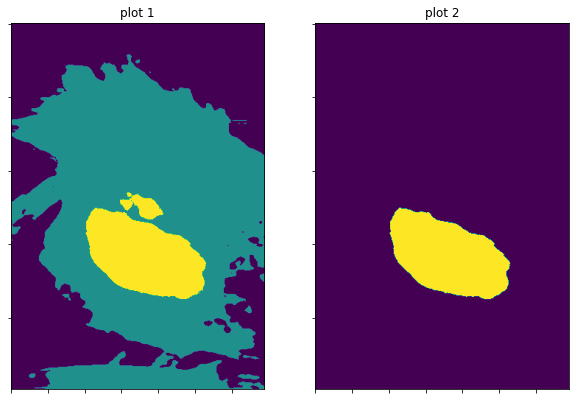

In [71]:
# maskleveles with respect to the kmeans
## nclusters -1 gets the top level


nerode= 3
lvls = [3]
maskN = getMaskLevels(img_labels,masklevels=lvls)

### Processing starts here
maskN = ndi.binary_erosion(maskN, iterations=nerode)

maskN = ndi.binary_fill_holes(maskN)


maskN = keepLargestArea(maskN)

maskN = ndi.binary_dilation(maskN, iterations=nerode)
maskN = ndi.binary_closing(maskN)

#distance = ndi.distance_transform_edt(maskN)
#coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=maskN)
#mask = np.zeros(distance.shape, dtype=bool)
#mask[tuple(coords.T)] = True
#markers, _ = ndi.label(mask)
#labels2 = watershed(-distance, markers, mask=maskN)
#maskN = labels2 >5
##print(np.unique(labels2))
#maskN = keepLargestArea(maskN)


compare(img_labels,maskN)

# Tidy up Cito

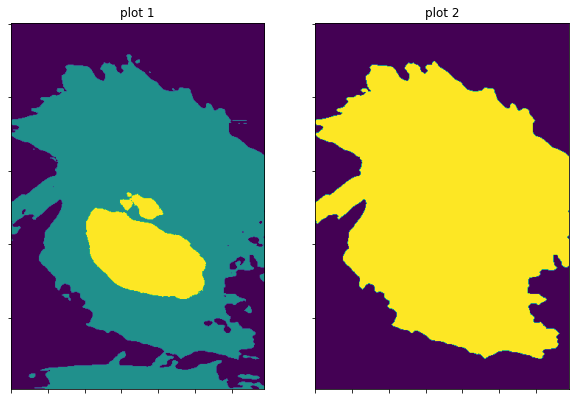

In [69]:
# maskleveles with respect to the kmeans
## nclusters -1 gets the top level


niters= 2
mls = [2]
maskC = getMaskLevels(img_labels,masklevels=mls) 


### Processing starts here
#maskC = keepLargestArea(maskC)
maskC = ndi.binary_fill_holes(maskC)
maskC = ndi.binary_erosion(maskC, iterations=niters)
maskC = keepLargestArea(maskC)

maskC = ndi.binary_dilation(maskC, iterations=niters)





compare(img_labels,maskC)

# Final Mask

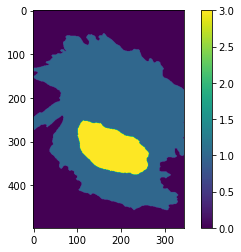

In [73]:
maskf = 1*maskC + 2*maskN
maskf = np.where(maskf > 3,3,maskf)
cc = plt.imshow(maskf)
plt.colorbar(cc)